In [ ]:
from nbdev import *
# default_exp source_data
#%nbdev_default_export source_data
%reload_ext autoreload
%autoreload 2

# Source Data management
> Extract data for a source

### Overview

Given a point source, the class `SourceData` manages all data-oriented operations, providing all that is necessary to create a set of cells. It depends on the modules

* `config` 
    This must set up the paths to the data created by `data_man`, and define paths for the effective area and weight files

* effective_area
* weights

It implements `binned_exposure`

In [ ]:
# export
import os, sys
import numpy as np
import pandas as pd
import healpy
import pickle
from pathlib import Path

from wtlike.config import *
from wtlike.data_man import *
from wtlike.effective_area import *
from wtlike.weights import *

In [ ]:
#  hide
# check the weekly files
config = Config(wtlike_data='~/wtlike_data', verbose=2)
if config.valid:
    ff = get_data_files(config)
    source = PointSource('BL Lac') #Geminga')
    print(source)

Configuration parameters 
  verbose         : 2
  wtlike_data     : /home/burnett/wtlike_data
  cachepath       : /home/burnett/wtlike_cache
  radius          : 4
  cos_theta_max   : 0.4
  z_max           : 100
  week_range      : (None, None)
  time_bins       : (0, 0, 7)
  use_uint8       : False
  nside           : 1024
  nest            : True
  bins_per_decade : 4
  base_spectrum   : lambda E: (E/1000)**-2.1
  energy_range    : (100.0, 1000000.0)
  likelihood_rep  : poisson

Weekly folder "/home/burnett/wtlike_data/data_files" contains 665 weeks, from 9 to 674
Most recent data to UTC 2021-05-06 00:45
Source "BL Lac" at: (l,b)=(92.590,-10.441)


In [ ]:
# export
def _exposure(config,  livetime, pcosine):
    """return exposure calculated for each pair in livetime and cosines arrays

    uses effective area
    """
    from scipy.integrate import simps
    assert len(livetime)==len(pcosine), 'expect equal-length arrays'

    # get a set of energies and associated weights from a trial spectrum

    emin,emax = config.energy_range
    loge1=np.log10(emin); loge2=np.log10(emax)

    edom=np.logspace(loge1, loge2, int((loge2-loge1)*config.bins_per_decade+1))
    if config.verbose>1:
        print(f'Calculate exposure using the energy domain'\
              f' {emin}-{emax} {config.bins_per_decade} bins/decade' )
    base_spectrum = eval(config.base_spectrum) #lambda E: (E/1000)**-2.1
    assert base_spectrum(1000)==1.
    wts = base_spectrum(edom)

    # effectivee area function from
    ea = EffectiveArea(file_path=config.wtlike_data/'aeff_files')

    # a table of the weighted for each pair in livetime and pcosine arrays
    rvals = np.empty([len(wts),len(pcosine)])
    for i,(en,wt) in enumerate(zip(edom,wts)):
        faeff,baeff = ea([en],pcosine)
        rvals[i] = (faeff+baeff)*wt

    aeff = simps(rvals,edom,axis=0)/simps(wts,edom)
    return (aeff*livetime)

def _calculate_exposure_for_source(config, source, week):
    """
    Calcualate the exposure for the source during the given week
    """
    df = week['sc_data']
    
    # calculate cosines with respect to sky direction
    sc = source
    ra_r,dec_r = np.radians(sc.ra), np.radians(sc.dec)
    sdec, cdec = np.sin(dec_r), np.cos(dec_r)

    def cosines( ra2, dec2):
        ra2_r =  np.radians(ra2.values)
        dec2_r = np.radians(dec2.values)
        return np.cos(dec2_r)*cdec*np.cos(ra_r-ra2_r) + np.sin(dec2_r)*sdec

    pcosines = cosines(df.ra_scz,    df.dec_scz)
    zcosines = cosines(df.ra_zenith, df.dec_zenith)
    # mask out entries too close to zenith, or too far away from ROI center
    mask =   (pcosines >= config.cos_theta_max) & (zcosines>=np.cos(np.radians(config.z_max)))
    if config.verbose>1:
        print(f'\tFound {len(mask):,} S/C entries:  {sum(mask):,} remain after zenith and theta cuts')
    dfm = df.loc[mask,:]
    livetime = dfm.livetime.values

    return  pd.DataFrame( 
        dict(
            start=df.start[mask], 
            stop=df.stop[mask], 
            exp=_exposure(config, livetime, pcosines[mask]),
            cos_theta=pcosines[mask],
        ))




### Check exposure with last data file

In [ ]:
#  hide
if config.valid:
    filename=ff[-1]
    week = pickle.load( open(filename,'rb') )
    e_df = _calculate_exposure_for_source(config, source, week); 
    print(e_df.head())

	Found 16,968 S/C entries:  5,808 remain after zenith and theta cuts
Calculate exposure using the energy domain 100.0-1000000.0 4 bins/decade
       start      stop       exp  cos_theta
46  59333.05  59333.05  59088.93       0.52
47  59333.05  59333.05  61695.12       0.53
48  59333.05  59333.05  64587.83       0.55
49  59333.05  59333.05  67566.50       0.56
50  59333.05  59333.05  70436.57       0.57


In [ ]:
# export

def _get_photons_near_source(config, source, week): #tzero, photon_df):
    """
    Select the photons near a source
    
    - source : a PointSource object
    - week : dict with 
        - tzero : start time for the photon
        - photon_df : DataFrame with photon data
    
    Returns a DF with 
    - `band` index, 
    - `time` in MJD (added tstart and converted from MET)
    - `pixel` index, nest indexing 
    - `radius` distance in deg from source direction
    """
    
    def _cone(config, source, nest=True):
        # cone geometry stuff: get corresponding pixels and center vector
        l,b,radius = source.l, source.b, config.radius
        cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
        conepix = healpy.query_disc(config.nside, cart(l,b), np.radians(radius), nest=nest)
        center = healpy.dir2vec(l,b, lonlat=True)
        return center, conepix
    
    center, conepix = _cone(config,source)

    df = week['photons']
    tstart = week['tstart']
    allpix = df.nest_index.values

    # select by comparing high-order pixels (faster)
    shift=11
    a = np.right_shift(allpix, shift)
    c = np.unique(np.right_shift(conepix, shift))
    incone = np.isin(a,c)
    
    if sum(incone)<2:
        if config.verbose>1:
            print(f'\nWeek at {UTC(MJD(tstart))} has 0 or 1 photons')
        return
    
    if config.verbose>2:
        a, b = sum(incone), len(allpix)
        print(f'Select photons for source {source.name}:\n\tPixel cone cut: select {a} from {b} ({100*a/b:.1f}%)')

    # cut df to entries in the cone
    dfc = df[incone]

    # distance from center for all accepted photons
    ll,bb = healpy.pix2ang(config.nside, dfc.nest_index,  nest=True, lonlat=True)
    cart = lambda l,b: healpy.dir2vec(l,b, lonlat=True)
    t2 = np.degrees(np.array(np.sqrt((1.-np.dot(center, cart(ll,bb)))*2), np.float32))
    in_cone = t2<config.radius

    if config.verbose>2:
        print(f'\tGeometric cone cut: select {sum(in_cone)}')
    # assume all in the GTI (should check)

    # times: convert to float, add tstart, convert to MJD
    time = MJD(np.array(dfc.time, float)+tstart)

    # assemble the DataFrame, remove those outside the radius
    out_df = pd.DataFrame(np.rec.fromarrays(
        [np.array(dfc.band), time, dfc.nest_index, np.atleast_1d(t2)],
        names='band time pixel radius'.split()))[in_cone]

    # make sure times are monotonic by sorting (needed for most weeks after March 2018)
    out_df = out_df.sort_values(by='time')
    
    return out_df

### test photon data 

In [ ]:
# #  hide
# # if config.valid:
# for i,f in enumerate(ff[300:]):
#     week = pickle.load(open(f,'rb')); 
#     tstart = week['tstart']
#     print(f'{i} ', end='')
#     #print(f'TSTART: MET {tstart}, UTC {UTC(MJD(tstart))}')
#     p_df = _get_photons_near_source(config, source, week )
# #     print(len(p_df))

In [ ]:
# export  
def contiguous_bins(exposure, min_gap=20, min_duration=600):
    
    """ return a dataframe with start and stop columns that 
    denote contiguous intervals
    
    """

    stop = exposure.stop.values
    start = exposure.start.values

    # interleave  the starts ane stops
    ssint = np.empty(2*len(start))
    ssint[0::2] = start
    ssint[1::2] = stop

    # Tag the (stpp,start) pairs < 10 sec as  not adjacent
    not_adjacent = np.diff(ssint)[1::2] > min_gap/(24*3600) ; 
    #print(f'{sum(not_adjacent)} (start,stop) pairs are not closer than {min_gap} s')

    # make a mask, keep ends
    mask = np.empty(2*len(start), bool)
    mask[0] = mask[-1] = True
    # 

    # insert into mask -- keep only the (stop,start) pairs  which are not adjacent
    mask[1:-2:2] = not_adjacent
    mask[2:-1:2] = not_adjacent
    
    # apply mask, split into start and stop
    keep = ssint[mask]
    return keep
#     gstart, gstop = keep[0::2], keep[1::2]
#     df =  pd.DataFrame.from_dict(dict(start=gstart, stop=gstop))
    
#     # add column with duration in sec
#     df.loc[:,'duration'] = (df.stop-df.start)*24*3600
#     return df.query(f'duration>{min_duration}')

def time_bin_edges(config, exposure, tbin=None):
    """Return an interleaved array of start/stop values
    
    tbin: an array (a,b,d), default config.time_bins
    
    interpretation of a, b:

        if > 5000, interpret as MJD
        if <0, back from stop
        otherwise, offset from start
        
    d : if positive, the day bin size
        if 0; return contiguous bins
        

    """
    # nominal total range, MJD edges
    start = np.round(exposure.start.values[0])
    stop =  np.round(exposure.stop.values[-1])

    a, b, step = tbin if tbin is not None else config.time_bins
    

    if a>50000: start=a
    elif a<0: start = stop+a
    else : start += a


    if b>5000: stop=b
    elif b>0: stop = start+b
    else: stop += b
    
    if step<=0:
        return contiguous_bins(exposure.query(f'{start}<start<{stop}'),)

    # adjust stop
    nbins = int((stop-start)/step)
    assert nbins>1, 'Bad binning: no bins'
    stop = start+(nbins)*step
    u =  np.linspace(start,stop, nbins+1 )
    
    # make an interleaved start/stop array
    v = np.empty(2*nbins, float)
    v[0::2] = u[:-1]
    v[1::2] = u[1:]
    return v

In [ ]:
exposure = e_df
print(time_bin_edges(config, exposure, (0,0,1)) )
print(time_bin_edges(config, exposure, (-1,0,0)))
# print(time_bin_edges(config, exposure, (0,0,0.5)) )
# print(time_bin_edges(config, exposure, (-5,0,2)) )
# print(time_bin_edges(config, exposure, (0,1,0.25)) )
# print(time_bin_edges(config, exposure, (-5,-4,0.25)) )   
# print(time_bin_edges(config, exposure, (59326, 59330,0.5)) )    
 

[59333. 59334. 59334. 59335. 59335. 59336. 59336. 59337. 59337. 59338.
 59338. 59339. 59339. 59340.]
[59339.00020583 59339.01895583 59339.06414102 59339.08497435
 59339.13015954 59339.13544294 59339.14687327 59339.15103917
 59339.19652528 59339.20268835 59339.26248593 59339.27045451
 59339.32885167 59339.33831331 59339.39490491 59339.40654248
 59339.46085398 59339.47860267 59339.52735861 59339.54784472
 59339.593435   59339.61392111 59339.65946509 59339.6799512
 59339.7255762  59339.74606231 59339.79169889 59339.812185
 59339.85809935 59339.87858546 59339.92411787 59339.94460398]


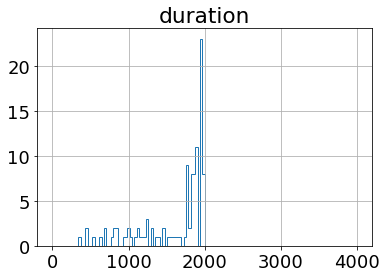

In [ ]:
keep = contiguous_bins(exposure)
gstart, gstop = keep[0::2], keep[1::2]
df =  pd.DataFrame.from_dict(dict(start=gstart, stop=gstop))

# add column with duration in sec
df.loc[:,'duration'] = (df.stop-df.start)*24*3600

df.hist('duration', bins=np.linspace(0,4e3,131));

In [ ]:
# export
def binned_exposure(config, exposure, time_edges):
    """Bin the exposure

    - time_bins: list of edges, as an interleaved start/stop array
       
        
    returns  array of exposure integrated over each time bin, times 1e-9
    it is interleaved, client must apply [0::2] selection.

    """

    # get exposure calculation
    exp   =exposure.exp.values
    estart= exposure.start.values
    estop = exposure.stop.values

    # determine bins,

    #use cumulative exposure to integrate over larger periods
    cumexp = np.concatenate(([0],np.cumsum(exp)) )

    # get index into tstop array of the bin edges
    edge_index = np.searchsorted(estop, time_edges)
    
    # return the exposure integrated over the intervals
    cum = cumexp[edge_index]
   
    # difference is exposure per interval: normalize it here
    bexp = np.diff(cum) 
#     if config.verbose>1:
#         print(f'Relative exposure per bin:\n{pd.Series(bexp).describe(percentiles=[])}')
    return bexp

In [ ]:
# export

def _load_from_weekly_data(config, source, week_range=None):
    """
    Generate combinded DataFrames from a list of pickled files
    Either weekly or monthly
    
    kwargs:
    - week_range
    """
    
    # check weights
    weight_file =  check_weights(config,  source)
    assert weight_file is not None
    
    data_folder = config.wtlike_data/'data_files'
    data_files = sorted(list(data_folder.glob('*.pkl')))
    iname = data_folder.name
    
    if config.verbose>0:
        print(f"\tAssembling photon data and exposure for source {source.name} from"\
              f' folder "{data_folder}",\n\t with {len(data_files)} files,'\
              f' last file:  {data_files[-1].name}: ', end='')
    
    w1,w2 = week_range or  config.week_range
    if w1 is not None or w2 is not None:
        if config.verbose>0:
            print(f'\tLoading weeks {t}')
        data_files= data_files[w1:w2]
    else:
        if config.verbose>0: print('loading all files')
            
            

    verbose, config.verbose=config.verbose, 0
    # list of data framees
    pp = []
    ee = []
    for f in data_files:
        print('.', end='')
        with open(f, 'rb') as inp:
            week = pickle.load(inp)

        photons = _get_photons_near_source(config, source, week )
        if photons is not None:
            pp.append(photons)
        ee.append(_calculate_exposure_for_source(config, source, week ))
    print('');    
    config.verbose=verbose
    # concatenate the two lists of DataFrames
    p_df = pd.concat(pp, ignore_index=True)
    e_df = pd.concat(ee, ignore_index=True)

    if config.verbose>1:
        times = p_df.time.values
        print(f'Loaded {len(p_df):,} photons from {UTC(times[0])} to  {UTC(times[-1])} ')
        print(f'Calculated {len(e_df):,} exposure entries')
        
    # add weights to photon data
    add_weights(config, p_df, source)
        
    return p_df, e_df

In [ ]:
# #  hide
# len(ff), ff[-132]
# _load_from_weekly_data(config, source, week_range=(-132, -100))

In [ ]:
# export
from wtlike.simulation import *
class SourceData(object):
    """ Load the photon data near the source and associated exposure. 
    
    Either from:
      1. `config.wtlike_data/'data_files'`, the Path to folder with list of pickle files
      2. the cache, with key `{source.name}_data`
    
    * source : name, PointSource, or Simulation
    * `config` : basic configuration
    * `source` : PointSource object if specified
    * `clear` : if set, overwrite the cached results
    
    Calculate the values for
    
    * S, B : sums of w and 1-w
    * exptot : total associated exposure
    """
    
    def __init__(self, source, config=None,  clear=False, 
                 week_range=None, key=''):
        """ 

        """
            
        self.config = config if config else Config()
        self.verbose = self.config.verbose
        self.simulated=False
        
        ## source is either a name, a PointSource object, or a Simulation
        if type(source)==str:

            try:
                self.source = PointSource(source) 
            except Exception as e:
                print(f'{e}', file=sys.stderr)
                raise

            self.source_name = self.source.name
 
        elif isinstance(source, PointSource):
            self.source = source # do I need this?
            self.source_name = source.name
            
        elif isinstance(source, Simulation):
            self.simulated=True
            self.source=None 
            self.source_name = source.name
            # can put this into cache
            source.run()
            self.photons = source.photons
            self.exposure = source.exposure

        key = f'{self.source_name}_data' if key=='' else key
        #self.source.data_key = key
        
        if not self.simulated:
            # either load from data, or from a chache
            if self.config.wtlike_data/'data_files' is None and key not in config.cache:
                raise Exception(f'Data for {self.source_name} is not cached, and config.wtlike_data/"data_files" is not set')

            photons, self.exposure = self.config.cache(key, 
                            _load_from_weekly_data, self.config, self.source, week_range,
                            overwrite=clear,
                            description=f'SourceData: photons and exposure for {self.source_name}')
        
            # get the photon data with good weights, not NaN (maybe remove small weigts, too)
            good = np.logical_not(np.isnan(photons.weight))
            self.photons = photons.loc[good]

        else: #TODO
            pass
        

            
        self.exptot = self.exposure.exp.sum() 

        # estimates for signal and background counts in total exposure
        w = self.photons.weight
        self.S = np.sum(w)
        self.B = np.sum(1-w)
        
        if self.verbose>0:
            print(SourceData.__repr__(self))
    
    def rates(self):
        print(f'Average rates for {self.source_name}: signal {self.S/self.exptot:.2e}/s, background {self.B/self.exptot:.2e}/s')

    def __repr__(self):
        time = self.photons.time.values
        if not self.simulated:
            photon_text = f' photons   from {UTC(time[0])[:10]} to {UTC(time[-1])[:10]}'
            exp_text = f' from {UTC(self.exposure.iloc[0].start)[:10]} to {UTC(self.exposure.iloc[-1].stop)[:10]}'
        else:
            photon_text = f' simulated photons'
            exp_text = f'over {self.exposure.iloc[-1].stop-self.exposure.iloc[0].start} days.'
        r = f'{self.__class__.__name__}: Source {self.source_name} with:'\
            f'\n\t data:     {len(self.photons):9,} {photon_text}'\
            f'\n\t exposure: {len(self.exposure):9,} intervals {exp_text}'
 
        src_rate, bkg_rate =self.S/self.exptot,  self.B/self.exptot
        r+= f'\n\t est. rates from weights: source {src_rate:.2e}/s, background {bkg_rate:.2e}/s, S/N ratio {src_rate/bkg_rate:.2f}'

        return r
    
    def binned_exposure(self, time_edges):
        """Bin the exposure
        
        - time_bins: list of edges.  
        """
        return binned_exposure(self.config, self.exposure,  time_edges)
    
    def binned_cos_theta(self, time_bins=None):
        """ Calculate average cosine of angle with respect to bore axis, per time bin
        """
        if time_bins is None:
            time_bins = get_default_bins(self.config, self.exposure)
        df = self.exposure.copy()
        estop =df.stop.values
        df.loc[:,'tbin'] =np.digitize(estop, time_bins)
        ct = df.groupby('tbin').mean()['cos_theta']
        return ct, time_bins
    
    def weight_histogram(self, nbins=1000, key=''):
        """ return a weight distribution
        """
        def doit(nbins):
            return np.histogram(self.p_df.weight.values, np.linspace(0,1,nbins+1))[0]

        key = f'{self.source_name}_weight_hist' if key=='' else key
        description = f'Weight histogram for {self.source_name}' if self.config.verbose>0 else ''
        return self.config.cache(key, doit, nbins, description=description)
        
    def plot_data(self):
        import matplotlib.pyplot as plt
        if self.simulated:
            print(f'Simulated!')
            fig, (ax1, ax4) = plt.subplots(1,2, figsize=(8,4))
            ax1.hist(self.photons.time.values, 500, histtype='step');
            ax1.set(xlabel='Time (MJD)')

            ax4.hist(self.photons.weight, 100, histtype='step')
            ax4.set(xlabel='weight');

            
        else:
            fig, (ax1,ax2, ax3,ax4) = plt.subplots(1,4, figsize=(15,4))
            ax1.hist(self.photons.time.values, 100, histtype='step');
            ax1.set(xlabel='Time (MJD)')
            ax2.hist(self.photons.radius.values**2, 100, histtype='step', log=True);
            ax2.set(xlabel='Radius**2 (deg**2)', ylim=(100, None));

            ax3.hist(self.photons.band, 32, histtype='step', log=True);
            ax3.set(xlabel='Band index')
            ax4.hist(self.photons.weight, 100, histtype='step')
            ax4.set(xlabel='weight');

In [ ]:
sim = Simulation('test_sim', src_flux=1e-6, tstart=0, tstop=30, )
simsd = SourceData(sim)

generated 2635 photons
SourceData: Source test_sim with:
	 data:         2,635  simulated photons
	 exposure:     8,640 intervals over 30.0 days.
	 est. rates from weights: source 1.03e-06/s, background 1.00e-06/s, S/N ratio 1.03


In [ ]:
#sd = SourceData('3C 279', week_range=(500,None), key=None)
sd = SourceData('Geminga');

SourceData: photons and exposure for Geminga: Restoring from cache with key "Geminga_data"
SourceData: Source Geminga with:
	 data:     1,213,841  photons   from 2008-08-04 to 2021-05-05
	 exposure: 3,117,669 intervals  from 2008-08-04 to 2021-05-06
	 est. rates from weights: source 3.28e-06/s, background 1.25e-06/s, S/N ratio 2.62


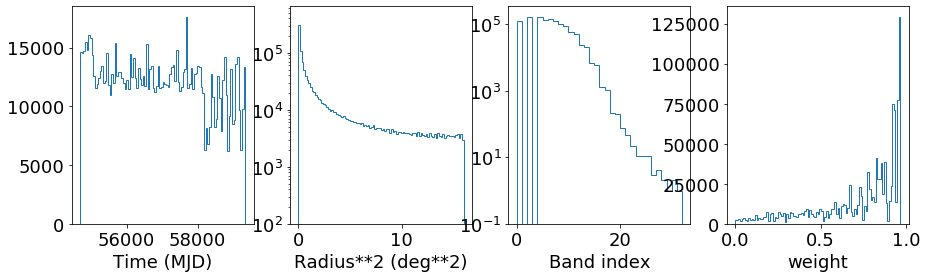

In [ ]:
sd.plot_data();

In [ ]:
#hide
show_doc(SourceData)
show_doc(SourceData.binned_exposure)

<h2 id="SourceData" class="doc_header"><code>class</code> <code>SourceData</code><a href="" class="source_link" style="float:right">[source]</a></h2>

> <code>SourceData</code>(**`source_name`**, **`config`**=*`None`*, **`clear`**=*`False`*, **`week_range`**=*`None`*, **`key`**=*`''`*)

Load the photon data near the source and associated exposure. 

Either from:
  1. `config.wtlike_data/'data_files'`, the Path to folder with list of pickle files
  2. the cache, with key `{source.name}_data`

* source : name, PointSource, or Simulation
* [`config`](/wtlikeconfig) : basic configuration
* `source` : PointSource object if specified
* `clear` : if set, overwrite the cached results

Calculate the values for

* S, B : sums of w and 1-w
* exptot : total associated exposure

<h4 id="SourceData.binned_exposure" class="doc_header"><code>SourceData.binned_exposure</code><a href="__main__.py#L106" class="source_link" style="float:right">[source]</a></h4>

> <code>SourceData.binned_exposure</code>(**`time_edges`**)

Bin the exposure

- time_bins: list of edges.  

In [ ]:
#hide
from nbdev.export import notebook2script
notebook2script()
!date

Converted 00_config.ipynb.
Converted 01_data_man.ipynb.
Converted 02_effective_area.ipynb.
Converted 03_weights.ipynb.
Converted 04_simulation.ipynb.
Converted 05_source_data.ipynb.
Converted 06_poisson.ipynb.
Converted 07_loglike.ipynb.
Converted 08_cell_data.ipynb.
Converted 09_lightcurve.ipynb.
Converted 14_bayesian.ipynb.
Converted 90-main.ipynb.
Converted 99_tutorial.ipynb.
Converted index.ipynb.
Mon May 10 17:14:27 PDT 2021
